# Planning

In [6]:
# distance function
import os
os.chdir('C:/Users/clack/Projects/nwm')

import torch
import torch.nn as nn
from experiment.vae import Encoder

class DistancePredictor(nn.Module):
  def __init__(self, bottleneck_channels: int, hidden_dim: int, classes: int) -> None:
    super().__init__()
    self.convolutional_layers = Encoder(
      block_config_str='8x6,8d2,8t4,4x4,4d4,4t1,1x4',
      channel_config_str='8:256,4:256,1:512',
      bottleneck_channels=bottleneck_channels,
      image_channels=8
    )
    self.mlp = nn.Sequential(
      nn.ReLU(),
      nn.Linear(bottleneck_channels, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, classes)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    convolved, _ = self.convolutional_layers(x)
    return self.mlp(convolved.reshape(x.shape[0], -1))

def make_distance_predictor():
  return DistancePredictor(32, 128, 64)

In [58]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Tuple


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    return tensor * std + mean

class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from experiment.nav2d import Topo

def sample():
  camera_size = 64
  while True:
    state = Topo.random(avoid_wall_start=True)
    # sample a target position
    target_position = None
    tries = 10
    while target_position is None or state.terrain[
      target_position.round().astype(np.int32)[1],
      target_position.round().astype(np.int32)[0]
    ] >= state.wall_height:
      if tries == 0:
        break
      tries -= 1
      
      # offset_upper_bound = state.terrain_size // 2 - camera_size // 2
      offset_upper_bound = 64
      # disproportionately sample small offsets
      biased_upper_bound = offset_upper_bound# np.random.rand() * offset_upper_bound
      target_position = state.position + biased_upper_bound * (np.random.rand(2) * 2 - 1)
    if target_position is None:
      continue

    distance = shortest_path(state, state.position, target_position, distance_only=True)
    if distance is None:
      continue
    assert isinstance(distance, float)
    if distance > offset_upper_bound:
      continue

    image1 = state.render(camera_size)
    image1 = transform(torch.from_numpy(image1).permute(2, 0, 1).to(torch.float32))

    state.position = target_position
    image2 = state.render(camera_size)
    image2 = transform(torch.from_numpy(image2).permute(2, 0, 1).to(torch.float32))
  
    return image1, image2, torch.tensor(distance, dtype=torch.float32)


import heapq


def shortest_path(
  state: Topo, start: np.ndarray, end: np.ndarray, max_distance: float | None = None, distance_only: bool = False, max_exploration: int = 8000
) -> Tuple[List[np.ndarray], float] | float | None:
  start_block = start.round().astype(np.uint32)
  end_block = end.round().astype(np.uint32)

  if state.terrain[start_block[1], start_block[0]] >= state.wall_height:
    return None
  if state.terrain[end_block[1], end_block[0]] >= state.wall_height:
    return None
  
  if max_distance is None:
    max_distance = float((np.abs(end_block - start_block).sum() * 4).item())


  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  def heuristic(pos):
    return np.linalg.norm(pos - end_block)

  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  shortest_distance_found = max_distance
  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  visited_count = 0
  heads = [(heuristic(start_block), 0.0, tuple(start_block))]
  while heads:
    _, distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True
    visited_count += 1
    if visited_count > max_exploration:
      return None
    
    if np.equal(head, end_block).all():
      shortest_distance_found = distance_from_start
      break

    if distance_from_start >= shortest_distance_found:
      continue

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < 0).any(-1) | (neighbors >= state.terrain_size).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist + heuristic(neighbor), dist, tuple(neighbor)))

  if shortest_distance_found == max_distance:
    return None

  if distance_only:
    return shortest_distance_found
  # reconstruct a shortest path
  path = [end_block]
  while not np.equal(path[-1], start_block).all():
    neighbors = [path[-1] + edge for edge in edges]
    valid_neighbors = [n for n in neighbors if 0 <= n[0] < state.terrain_size and 0 <= n[1] < state.terrain_size]
    neighbor_closest_to_start = valid_neighbors[np.argmin(np.array([distance[neighbor[1], neighbor[0]] for neighbor in valid_neighbors]))]
    path.append(neighbor_closest_to_start)
  return list(reversed(path)), shortest_distance_found


def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample,
    # transform=transform
  )
# trainloader = torch.utils.data.DataLoader(nav2d_dataset(5000), batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=64, shuffle=True)


def smooth_labels(num_classes: int, decay: float, logarithmic_march: float = 1.0, iterations: int = 10) -> torch.Tensor:
  # b^num_classes = decay * logarithmic_march
  # b = (decay * logarithmic_march)^1/num_classes
  labels = torch.eye(num_classes)
  base = logarithmic_march ** (1 / (num_classes - 1))
  decay_vector = decay * torch.pow(torch.tensor(base), torch.arange(num_classes)).unsqueeze(1)
  for _ in range(iterations):
    transfer = labels * decay_vector
    labels -= transfer
    right_transfer = transfer.roll(1, dims=0) / 2
    right_transfer[-1] += right_transfer[0]
    right_transfer[0] = 0

    left_transfer = transfer.roll(-1, dims=0) / 2
    left_transfer[0] += left_transfer[-1]
    left_transfer[-1] = 0
    labels += right_transfer + left_transfer
  pileup = labels.max(-1).values > labels.max(-1).values.roll(1)
  pileup[0] = False
  while pileup.any():
    transfer = labels * decay_vector
    labels[pileup] -= transfer[pileup]
    right_transfer = transfer.roll(1, dims=0) / 2
    right_transfer[-1] += right_transfer[0]
    right_transfer[0] = 0

    left_transfer = transfer.roll(-1, dims=0) / 2
    left_transfer[0] += left_transfer[-1]
    left_transfer[-1] = 0
    labels[pileup] += (right_transfer + left_transfer)[pileup]
    
    pileup = labels.max(-1).values > labels.max(-1).values.roll(1)
    pileup[0] = False
  # labels /= labels.sum(-1)
  return labels

tensor([8.6755e-01, 1.2860e-01, 8.7771e-03, 3.3757e-04, 7.6419e-06, 9.6236e-08,
        5.2599e-10, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

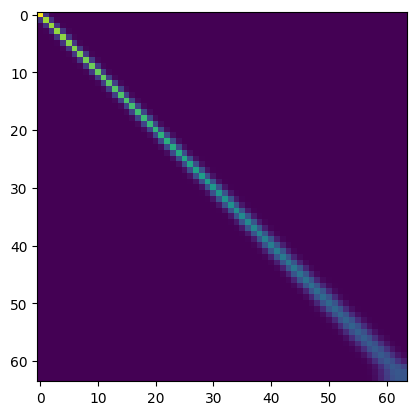

In [64]:
labels = smooth_labels(64, 0.05, iterations=6, logarithmic_march=10)
# labels[-4] = 0
plt.imshow(labels)
# plt.plot(smooth_labels(64, 0.05, iterations=40, logarithmic_march=16)[63])
labels[0]

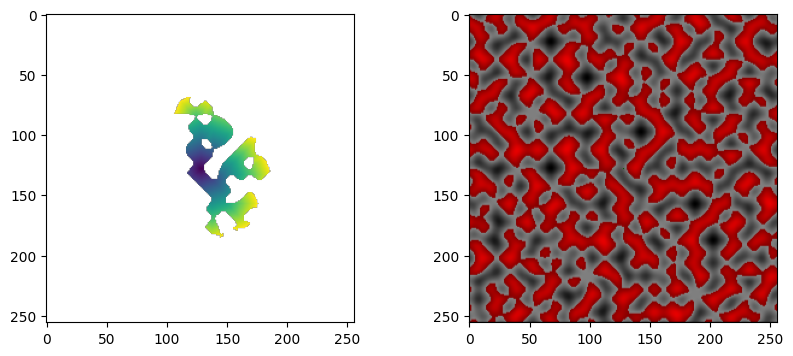

In [8]:
import heapq

import matplotlib.pyplot as plt
from tqdm import tqdm

def distance_map(
  state: Topo, start: np.ndarray, max_distance: float, forbidden_margin: int = 0
) -> np.ndarray:
  start_block = start.round().astype(np.uint32)
  
  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  heads = [(0.0, tuple(start_block))]
  
  while heads:
    distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < forbidden_margin).any(-1) | (neighbors >= state.terrain_size - forbidden_margin).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist, tuple(neighbor)))

  return distance


class TrajectoryDistanceSamplingDataset(torch.utils.data.Dataset):
  def __init__(self, size: int, samples_per_state: int, max_distance: int):
    super().__init__()
    self.size = size
    self.samples_per_state = samples_per_state
    self.max_distance = max_distance
    self.current_state = Topo.random()
    self.current_state_dist_map = distance_map(
      self.current_state,
      self.current_state.position,
      self.max_distance,
      forbidden_margin=96
    )
    self.reachable_positions = np.argwhere(~np.isinf(self.current_state_dist_map))
    self.start_image = self.current_state.render(64)
    self.current_state_sample_count = 0

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if self.current_state_sample_count == self.samples_per_state:
      self.current_state_sample_count = 0
      self.current_state = Topo.random()
      self.current_state_dist_map = distance_map(
        self.current_state,
        self.current_state.position,
        self.max_distance,
        forbidden_margin=96
      )
      self.reachable_positions = np.argwhere(~np.isinf(self.current_state_dist_map))
      self.start_image = self.current_state.render(64)
    target_position = self.reachable_positions[np.random.randint(0, len(self.reachable_positions))]
    self.current_state.position = np.array([target_position[1], target_position[0]], dtype=np.float32)
    target_image = self.current_state.render(64)
    distance = self.current_state_dist_map[target_position[0], target_position[1]]
    return (
      transform(torch.from_numpy(self.start_image).permute(2, 0, 1).to(torch.float32)),
      transform(torch.from_numpy(target_image).permute(2, 0, 1).to(torch.float32)),
      torch.tensor(distance)
    )
  
class PresampledDataset(torch.utils.data.Dataset):
  def __init__(self, dataset: torch.utils.data.Dataset) -> None:
    super().__init__()
    self.dataset = tqdm([sample for sample in dataset], desc='Preloading dataset')

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index: int):
    return self.dataset[index]
  
def new_dataloader(size: int, max_distance: int = 64):
  return torch.utils.data.DataLoader(
    # PresampledDataset(
    (
      TrajectoryDistanceSamplingDataset(size, samples_per_state=16, max_distance=max_distance)
    ),
    batch_size=64,
    shuffle=True
  )

state = Topo.random()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(distance_map(state, state.position, 64, forbidden_margin=32))
axes[1].imshow(state.render(256))

tensor([27.3848])


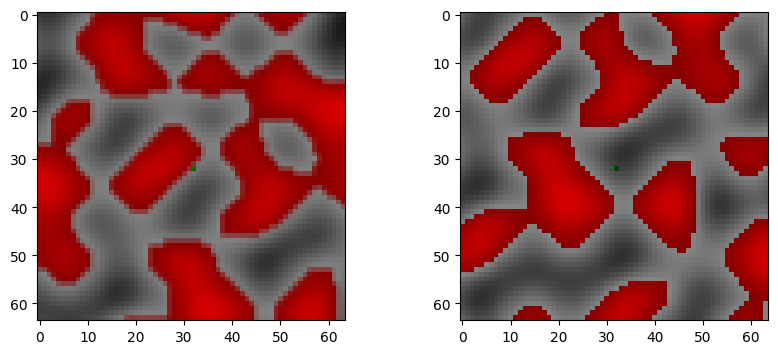

In [319]:
for image1, image2, distance in new_dataloader(1):
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  axes[0].imshow(denormalize(image1[0].permute(1, 2, 0)))
  axes[1].imshow(denormalize(image2[0].permute(1, 2, 0)))
  print(distance)
  

In [69]:
import glob
import json
from pathlib import Path
from tqdm import tqdm

from experiment.vae import make_vae

SAVE_DIR = Path('checkpoints/distance/v5+conv+curr+4lr')
os.makedirs(SAVE_DIR, exist_ok=True)
torch.cuda.empty_cache()
device = 'cuda'
vae = make_vae().to(device)
vae.load_state_dict(torch.load('checkpoints/vae/topo/check59.pt'))
vae.eval()
for param in vae.parameters():
  param.requires_grad = False
distance_predictor = make_distance_predictor().to(device)


latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
if latest_checkpoint_number >= 0:
  print(f'Resuming and starting epoch {latest_checkpoint_number + 1}.')
  distance_predictor.load_state_dict(torch.load(SAVE_DIR / f'check{latest_checkpoint_number}.pt'))
  with open(SAVE_DIR / f'stats{latest_checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  loss_log = train_stats['loss_log']
  samples = train_stats['samples']
  epoch = latest_checkpoint_number + 1
else:
  loss_log = []
  samples = 0
  epoch = 0

optimizer = torch.optim.Adam(distance_predictor.parameters(), lr=1e-4)
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()

# LABELS = smooth_labels(64, 0.05, iterations=40, logarithmic_march=16).to(device)
LABELS = smooth_labels(64, 0.05, iterations=6, logarithmic_march=12).to(device)
while epoch < 250:
  max_distance = int(max(2, min(1, (epoch - 2) / 64) * 64))
  for image1, image2, distance in tqdm(new_dataloader(10000, max_distance), desc=f'Epoch {epoch} - max_distance={max_distance}'):
    image1 = image1.to(device)
    image2 = image2.to(device)
    with torch.no_grad():
      latents = vae.encode(torch.cat((image1, image2), dim=0))
      latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
      x = torch.cat((latent1, latent2), dim=1).to(device)
      x = x.detach()
    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    # loss = criterion(prediction, y)
    y_smooth = LABELS[y]
    loss = -(y_smooth * torch.log_softmax(prediction, dim=1)).sum(dim=1).mean()

    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(distance_predictor.parameters(), 1.0)
    optimizer.step()

    loss_log.append(loss.item())
    samples += image1.shape[0]
  print(f'Epoch average loss: {sum(loss_log) / len(loss_log)}')
  train_stats = {
    'loss_log': loss_log,
    'samples': samples
  }
  with open(SAVE_DIR / f'stats{epoch}.json', 'w') as f:
    json.dump(train_stats, f, indent=2)
  loss_log = []
  torch.save(distance_predictor.state_dict(), SAVE_DIR / f'check{epoch}.pt')
  epoch += 1

Resuming and starting epoch 241.


Epoch 241 - max_distance=64: 100%|██████████| 157/157 [01:37<00:00,  1.60it/s]


Epoch average loss: 2.1960067544013833


Epoch 242 - max_distance=64: 100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Epoch average loss: 2.285776298516875


Epoch 243 - max_distance=64: 100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Epoch average loss: 2.0854245287597557


Epoch 244 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch average loss: 1.890233873561689


Epoch 245 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch average loss: 2.2956980444063806


Epoch 246 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.57it/s]


Epoch average loss: 2.141566978138723


Epoch 247 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch average loss: 2.2242109919809234


Epoch 248 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.57it/s]


Epoch average loss: 1.986739697729706


Epoch 249 - max_distance=64: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s]

Epoch average loss: 2.224957733397271


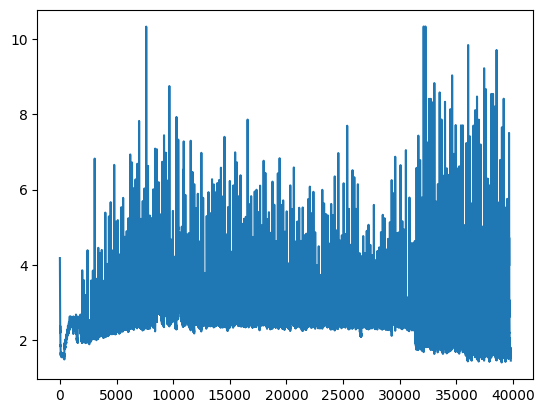

In [70]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('checkpoints/distance/v5+conv+curr+4lr')
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
raw_losses = []
for checkpoint_number in range(latest_checkpoint_number + 1):
  with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_losses.extend(train_stats['loss_log'])

plt.plot(raw_losses)
plt.show()

In [71]:
with torch.no_grad():
  errors = []
  actual = []
  predicted = []
  for image1, image2, distance in tqdm(testloader, desc=f'Testing'):
    image1 = image1.to(device)
    image2 = image2.to(device)

    latents = vae.encode(torch.cat((image1, image2), dim=0))
    latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
    x = torch.cat((latent1, latent2), dim=1).to(device)
    x = x.detach()

    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    errors.append(prediction.argmax(-1) - distance.to(device))
    actual.append(distance)
    predicted.append(prediction.argmax(-1))
  errors = torch.cat(errors)
  print(errors.mean(), errors.std())

Testing: 100%|██████████| 16/16 [01:57<00:00,  7.35s/it]

tensor(-1.8151, device='cuda:0') tensor(19.0613, device='cuda:0')


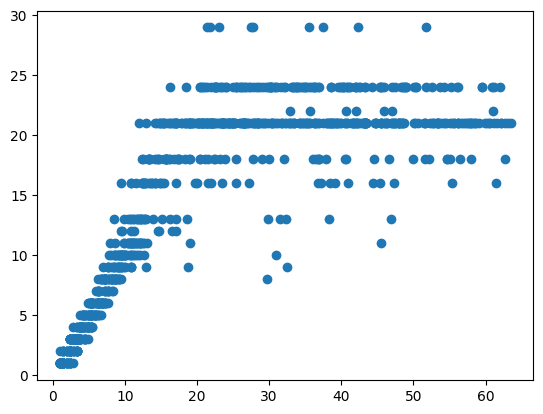

In [82]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

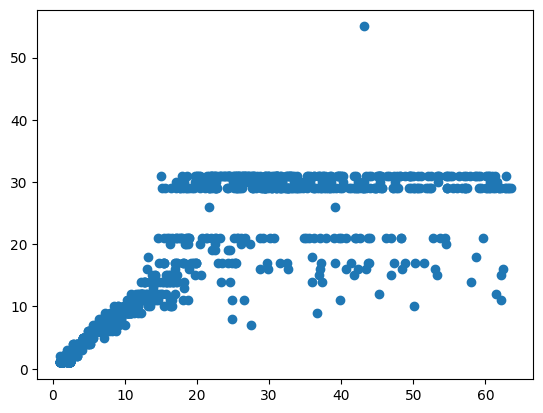

In [86]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

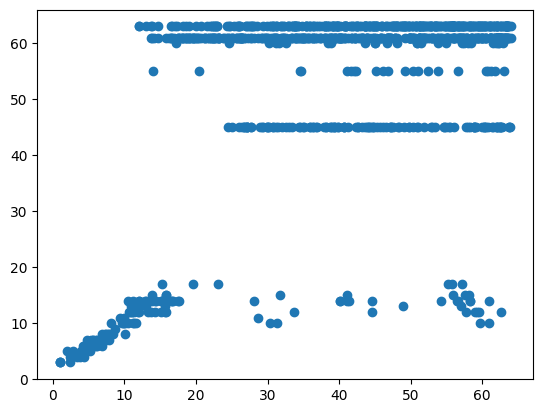

In [91]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

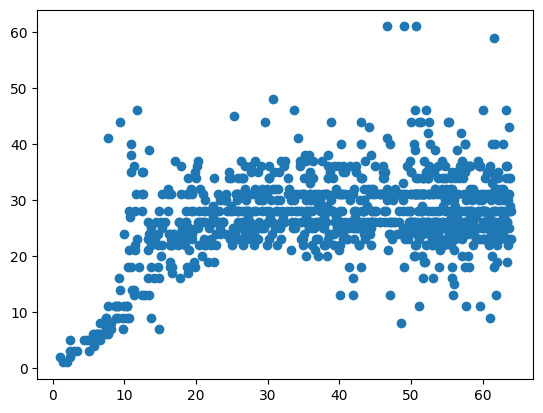

In [323]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

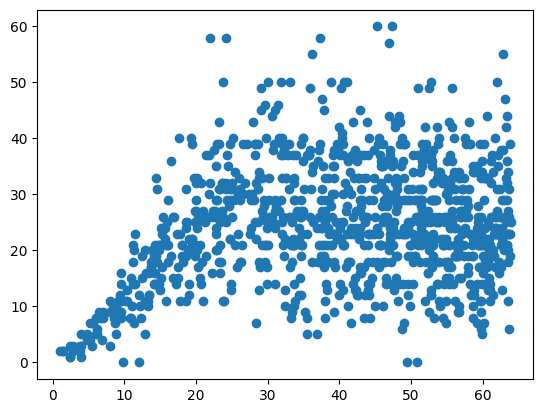

In [327]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

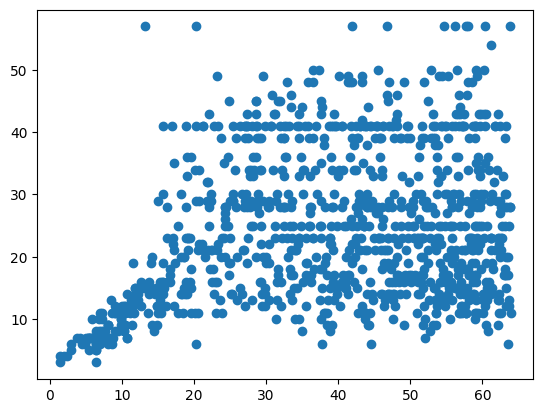

In [387]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

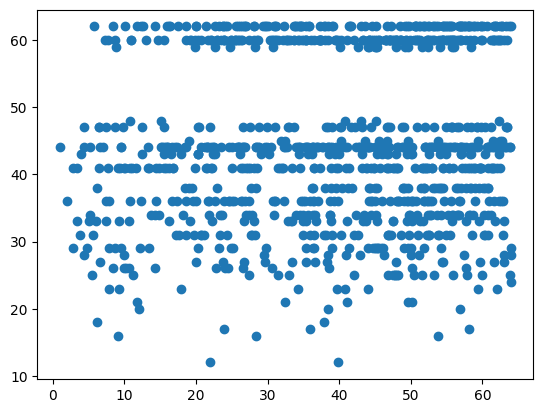

In [405]:
plt.scatter(torch.cat(actual).cpu(), torch.cat(predicted).cpu())

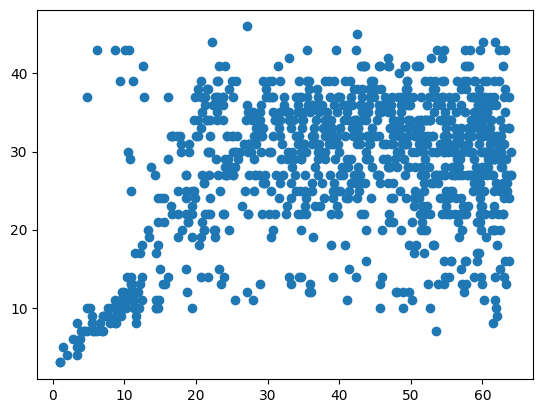

In [427]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

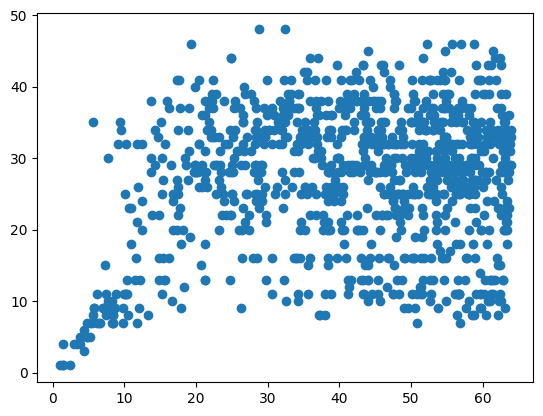

In [438]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

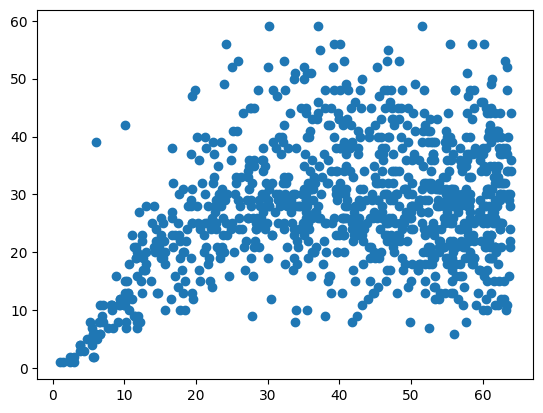

In [14]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

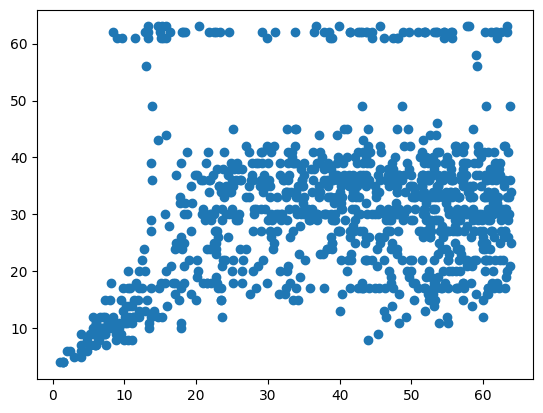

In [36]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

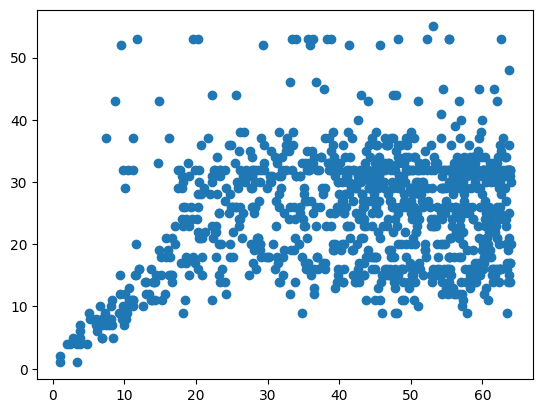

In [68]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

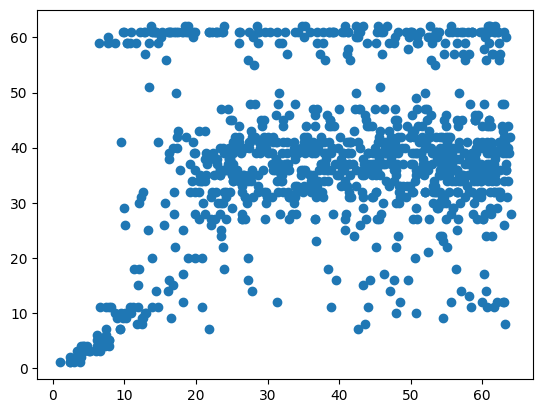

In [72]:
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(predicted).cpu()[filter_points])

In [83]:
with torch.no_grad():
  errors = []
  actual = []
  predicted = []
  for image1, image2, distance in tqdm(testloader, desc=f'Testing'):
    image1 = image1.to(device)
    image2 = image2.to(device)

    latents = vae.encode(torch.cat((image1, image2), dim=0))
    latent1, latent2 = latents[:image1.shape[0]], latents[image1.shape[0]:]
    x = torch.cat((latent1, latent2), dim=1).to(device)
    x = x.detach()

    y = distance.to(device).round().clamp(0, 63).to(dtype=torch.long)
    
    prediction = distance_predictor(x)
    errors.append(prediction.argmax(-1) - distance.to(device))
    actual.append(distance)
    predicted.append(prediction)
  errors = torch.cat(errors)
  print(errors.mean(), errors.std())

Testing: 100%|██████████| 16/16 [01:54<00:00,  7.17s/it]

tensor(-3.0182, device='cuda:0') tensor(18.2570, device='cuda:0')


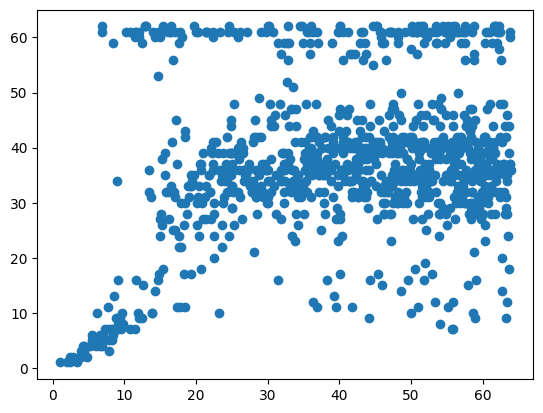

In [96]:
softmaxed = [(pred.softmax(-1).cpu() * torch.arange(64)).sum(-1, keepdim=True) for pred in predicted]
argmaxed = [pred.argmax(-1).cpu() for pred in predicted]
# print(len(softmaxed))
filter_points = torch.cat(actual).cpu() <= 64
plt.scatter(torch.cat(actual).cpu()[filter_points], torch.cat(argmaxed)[filter_points])

In [489]:
import matplotlib.pyplot as plt
state = Topo.random()
start_time = time.perf_counter()
path = shortest_path(state, np.array([128, 128]), np.array([100, 120]))
while path is None:
  state = Topo.random()
  path = shortest_path(state, np.array([128, 128]), np.array([100, 120]))
print(time.perf_counter() - start_time)
path

0.01288389999535866


([array([128, 128]),
  array([127, 127]),
  array([126, 126]),
  array([125, 125]),
  array([124, 124]),
  array([123, 123]),
  array([122, 122]),
  array([121, 121]),
  array([120, 120]),
  array([119, 119]),
  array([118, 118]),
  array([117, 117]),
  array([116, 116]),
  array([115, 115]),
  array([114, 114]),
  array([113, 113]),
  array([112, 113]),
  array([111, 112]),
  array([110, 112]),
  array([109, 112]),
  array([108, 112]),
  array([107, 113]),
  array([106, 114]),
  array([105, 115]),
  array([104, 116]),
  array([103, 117]),
  array([102, 118]),
  array([101, 119]),
  array([100, 120], dtype=uint32)],
 np.float64(37.941125496954285))

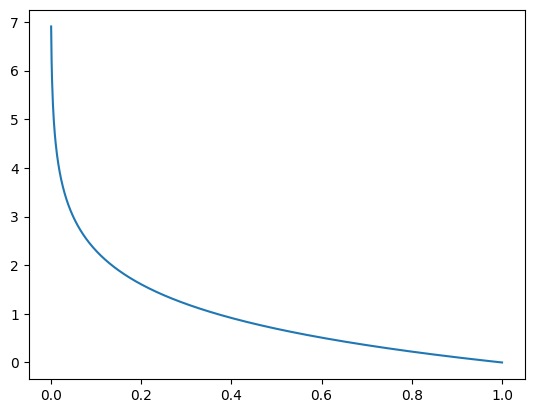

In [6]:
import matplotlib.pyplot as plt
z = np.linspace(0.001, 1, 1000)
plt.plot(z, -np.log(z)) 